<div align="center">
<a href="https://vbti.nl"><img src="./vbti_logo.png" width="400"></a>
</div>

# IMBD - Word2vec

In this notebook we continue with the IMDB dataset and start building word2vec models to predict the movie score.

## Read file

First, read the data from the pickles files generates by the first notebook.

In [1]:
# load some common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def download_file(url, path):
    """
    Download file and save it to the defined location
    
    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests/37573701
    """
    import requests
    from tqdm.notebook import tqdm
    import os
    
    
    if os.path.exists(path):
        print('File "{}" already exists. Skipping download.'.format(path))
        return
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

In [3]:
# read pickle files
import pickle

download_file('https://github.com/illyakaynov/masterclass-nlp/blob/master/Case-IMBD_reviews/train_data.pickle?raw=true',
             path='train_data.pickle')

download_file('https://github.com/illyakaynov/masterclass-nlp/blob/master/Case-IMBD_reviews/test_data.pickle?raw=true',
             path='test_data.pickle')


filename = './train_data.pickle'
with open(filename, 'rb') as file_object:
    train_data = pickle.load(file_object)
    
filename = './test_data.pickle'
with open(filename, 'rb') as file_object:
    test_data = pickle.load(file_object)    

File "train_data.pickle" already exists. Skipping download.
File "test_data.pickle" already exists. Skipping download.


# Word2vec

In [3]:
# prepare data for gensim
# data needs to be presented as a list of list of words
sentences = []
for review in train_data[0]:
    sentences.append(review.split(' '))

In [4]:
# If not installed, install gensim
# gensim is a library for NLP, see https://pypi.org/project/gensim/
!pip install gensim

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [5]:
from gensim.models.word2vec import Word2Vec

# vector-space embedding
n_dim = 64
n_context = 3

model_w2v = Word2Vec(sentences, size=n_dim, window=n_context, min_count=1, sample=1e-3, workers=4)
model_w2v.init_sims(replace=True)

In [6]:
# print vector embedding of word 'movie'
model_w2v.wv['movie']

array([-0.10106008,  0.23141234,  0.14407393,  0.0651494 ,  0.03511006,
       -0.09741589, -0.3000035 ,  0.04205281, -0.0023272 , -0.06070573,
        0.05952628,  0.07532372, -0.00788311, -0.07611571, -0.19255298,
        0.09119014,  0.01431286,  0.01442997,  0.16946746, -0.13730265,
        0.03976493, -0.21944122,  0.1349574 ,  0.19544111,  0.2884231 ,
        0.0558784 , -0.25215244, -0.02380151, -0.0450629 , -0.08639999,
        0.14911272,  0.05382146,  0.167637  , -0.0244073 , -0.08034657,
       -0.121162  , -0.07864779,  0.0115011 ,  0.1637629 , -0.03936552,
        0.12726739, -0.41688138, -0.10684593,  0.03514245, -0.00412911,
       -0.16942947,  0.03226681, -0.17637838, -0.09954221, -0.03243239,
       -0.05797489, -0.01821933, -0.01733863,  0.02767378,  0.01943791,
        0.00786668, -0.07073791,  0.06287944,  0.00123897,  0.07981132,
       -0.02227575,  0.04089396, -0.12167346, -0.0942134 ], dtype=float32)

Next, use the model to see which words are similar.

In [7]:
model_w2v.wv.most_similar('nice', topn=10)

[('cool', 0.7804254293441772),
 ('neat', 0.7401530742645264),
 ('creepy', 0.7349182367324829),
 ('cute', 0.7114131450653076),
 ('odd', 0.7070688009262085),
 ('pleasant', 0.7065705060958862),
 ('awesome', 0.704014003276825),
 ('good', 0.6981158256530762),
 ('decent', 0.6844236254692078),
 ('terrific', 0.6788299679756165)]

In [8]:
model_w2v.wv.most_similar('bad', topn=10)

[('terrible', 0.8117678165435791),
 ('horrible', 0.7976785898208618),
 ('awful', 0.7850826382637024),
 ('sucks', 0.7708120346069336),
 ('lousy', 0.7471089363098145),
 ('good', 0.7208129167556763),
 ('crappy', 0.7202004194259644),
 ('stupid', 0.7114221453666687),
 ('okay', 0.7092524766921997),
 ('caviar', 0.7041173577308655)]

In [9]:
model_w2v.wv.most_similar('schwarzenegger', topn=10)

[('kazaam', 0.9064536094665527),
 ('incubus', 0.9017022848129272),
 ('pompous', 0.8979527354240417),
 ('siegel', 0.8969791531562805),
 ('typifies', 0.8935072422027588),
 ('stallone', 0.8930180072784424),
 ('kusturica', 0.890600860118866),
 ('stoner', 0.8901408910751343),
 ('lecter', 0.8875051140785217),
 ('partial', 0.8869733810424805)]

## Visualize word vectors

Word vectors are high dimensional vectors. To plot them, we need to transform them to either 2D or 3D vectors. In the example below, we use the t-SNE (t-distributed stochastic neighbor embedding) algorithm for this.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000)
X2D = tsne.fit_transform(model_w2v.wv[model_w2v.wv.vocab])
coords_df = pd.DataFrame(X2D, columns=['x', 'y'])
coords_df['token'] = model_w2v.wv.vocab.keys()

In [ ]:
# save tsne data to file
coords_df.to_csv('./tsne.csv')

In [10]:
# load tsne data from file
coords_df = pd.read_csv('./tsne.csv')

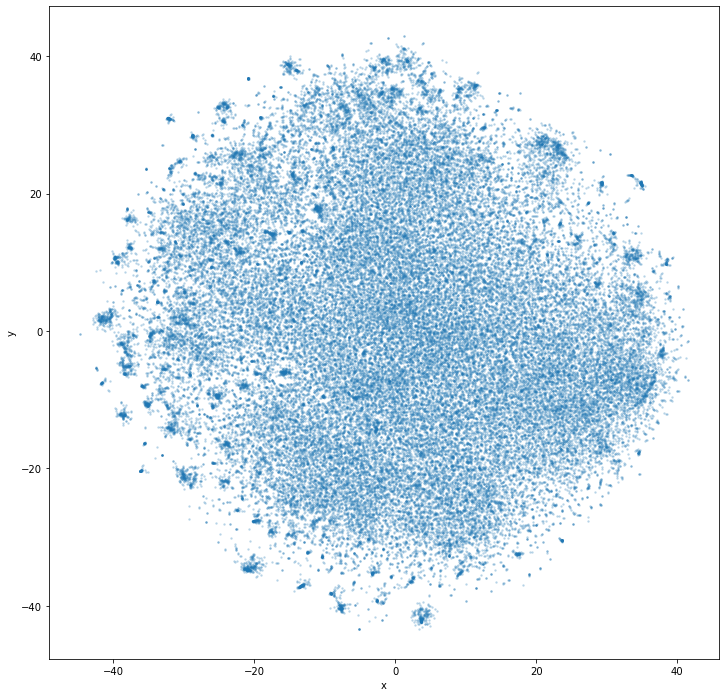

In [11]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12), marker='.', s=10, alpha=0.2)

In [12]:
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

output_notebook()
subset_df = coords_df.sample(n=5000)
p = figure(plot_width=800, plot_height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token, text_font_size="10pt")
show(p)

Loading BokehJS ...

In [13]:
# lookup coordinates for a word
coords_df['x'].values[coords_df['token']=='nice'], coords_df['y'].values[coords_df['token']=='nice']

(array([-7.9451895]), array([35.722893]))

# Prepare document vectors

To use word2vec with machine learning models, the input dimensions of the data need to be constant. However, the lenght (number of words) per review varies, as can be seen below. 

In [14]:
# print some length of reviews
for i in range(10):
    print(len(sentences[i]))

154
86
82
63
120
54
69
78
62
17


To fix this, every review will be represented by the average of all word vectors. This is done with the function below.

In [15]:
def featurize_w2v(model, sentences):
    f = np.zeros((len(sentences), model.vector_size))
    for i, s in enumerate(sentences):
        for w in s:
            try:
                vec = model.wv[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        f[i,:] = f[i,:] / len(s)
    return f

In [16]:
X_train = featurize_w2v(model_w2v, sentences)
y_train = np.array(train_data[1])

In [17]:
# all reviews are now represented by a n_dim dimensional vector
X_train.shape

(25000, 64)

Now, also transfor the test data.

In [18]:
sentences = []
for review in test_data[0]:
    sentences.append(review.split(' '))
X_test = featurize_w2v(model_w2v, sentences)
y_test = np.array(test_data[1])

# Machine learning model building

In [19]:
# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          ax=None,
                          figsize=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax==None:
        _, ax = plt.subplot(1, 1, figsize=figsize)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, pad=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.tick_params(axis='x', rotation=90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')    
    ax.set_ylim((len(classes) - 0.5, -0.5))

    
def accuracy(y, y_pred):
    return np.sum(y==y_pred)/len(y)


def plot_model_performance(model, X_train, y_train, X_test, y_test, label_names, figsize=(8,6)):
    """Support function for quickly plotting model performance."""
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs.ravel()

    y_train_pred = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(cm_train, 
                          list(label_names), 
                          title='Training - accuracy: {:.2f}'.format(accuracy(y_train, y_train_pred)),
                          ax=axs[0])

    y_test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm_test, 
                          list(label_names), 
                          title='Test - accuracy: {:.2f}'.format(accuracy(y_test, y_test_pred)),
                          ax=axs[1])

    plt.tight_layout()    

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

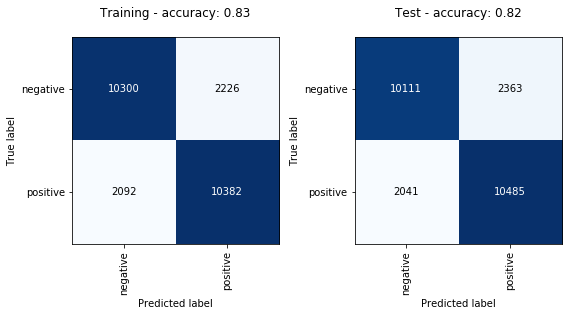

In [21]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
model = RandomForestClassifier(n_estimators = 100, max_depth=6) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
model = model.fit( X_train, y_train )

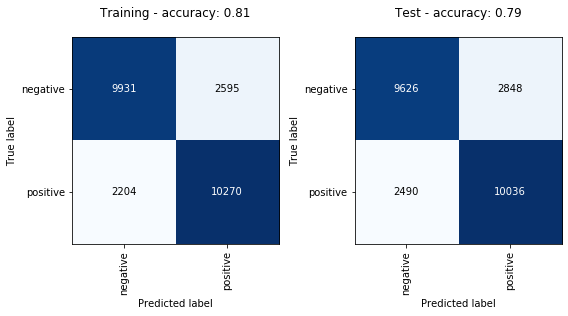

In [23]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])